sigmoid 사용 => 정규화 필요
- 층이 깊어질 수록 가중치 값들이 중간값인 0.5로 몰리는 현상이 발생

In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data

import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
tf.__version__

'1.15.0'

### Deep Neural Network

In [4]:
train_epoch = 15
batch_size = 100

In [5]:
x = tf.placeholder(tf.float32, shape=[None,28*28])
y = tf.placeholder(tf.float32, shape=[None, 10])

In [6]:
w1 = tf.get_variable(name="w1", shape=[28*28, 256],initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([256]))
l1 = tf.nn.relu(tf.matmul(x,w1)+b1)

w2 = tf.get_variable(name="w2", shape=[256, 256],initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([256]))
l2 = tf.nn.relu(tf.matmul(l1,w2)+b2)

w3 = tf.get_variable(name="w3", shape=[256, 256],initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([256]))
l3 = tf.nn.relu(tf.matmul(l2,w3)+b3)

w4 = tf.get_variable(name="w4", shape=[256, 256],initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([256]))
l4 = tf.nn.relu(tf.matmul(l3,w4)+b4)

w5 = tf.get_variable(name="w5", shape=[256,10],initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))

hf = tf.matmul(l4,w5)+b5

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



xavier
- np.random.randn(입력노드수, 출력노드수) / np.sqrt(입력노드수)
- tf.contrib.layers.xavier_initializer()

he
- np.random.randn(입력노드수, 출력노드수) / np.sqrt(입력노드수/2)
- tf.keras.initializers.he_normal()

### 가중치 업데이트 방법
- 기존(전통적) 경사하강법 : 매번 미분해야함 => 속도 느림

- 확률적 경사하강법(sgd) : 속도 개선

- 모멘텀(momentum) sgd : 확률적 경사하강법 + 관성
- 아다그리드 : step size 개선
- rmsprop : 아다그리드 개선
- adam : 모멘텀 + rmsprop

In [7]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=hf, labels=y))

optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

prediction = tf.equal(tf.argmax(hf,1),tf.argmax(y,1))

accuracy = tf.reduce_mean(tf.cast(prediction,tf.float32))

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_epoch = 15 
batch_size = 100
for epoch in range(train_epoch):
    avgCost=0
    total_batch = int(mnist.train.num_examples/batch_size)
    
    pbar = tqdm(range(total_batch))
    for i in pbar:
        batchX, batchY = mnist.train.next_batch(batch_size)
        cv,_ = sess.run([cost, optimizer],feed_dict={x:batchX, y:batchY})
        avgCost += cv/total_batch
        pbar.set_description("cost:%f"%avgCost)
print("정확도:",sess.run(accuracy,feed_dict={x:mnist.test.images, y:mnist.test.labels}))

cost:0.017908: 100%|████████████████████████████████████████████████████████████████| 550/550 [00:03<00:00, 180.09it/s]


정확도: 0.9799


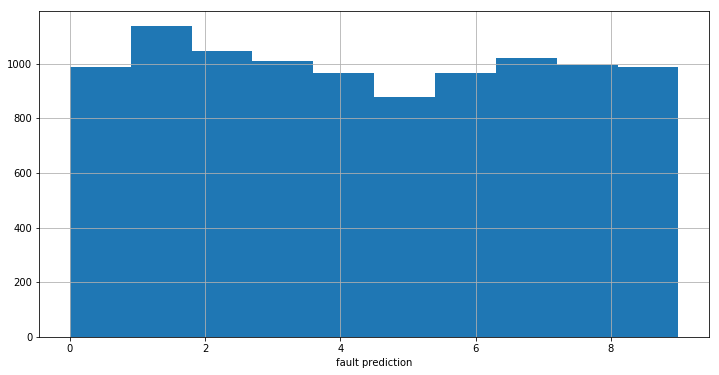

In [9]:
index=[]
ori=[]
pred=[]
labels = sess.run(tf.argmax(mnist.test.labels,1))
predictions = sess.run(tf.argmax(hf,1), feed_dict={x:mnist.test.images})

for i in range(mnist.test.num_examples):
    if prediction[i] != labels[i]:
        index.append(i)
        ori.append(labels[i])
        pred.append(predictions[i])
res = pd.DataFrame({'label':ori, "predict":pred},index=index)

plt.figure(figsize=(12,6))
plt.hist(res['predict'],bins=10)
plt.xlabel('fault prediction')
plt.grid()
plt.show()

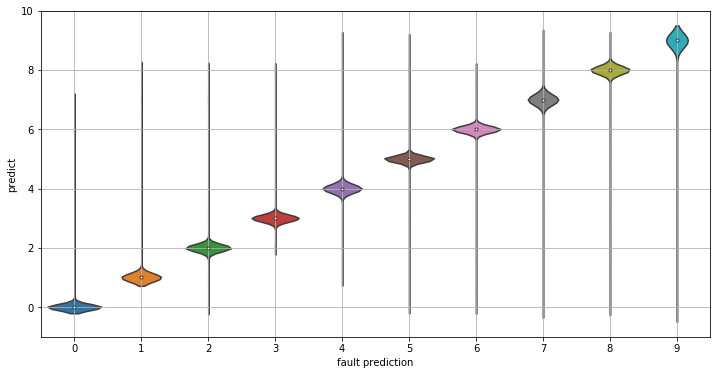

In [10]:
plt.figure(figsize=(12,6))
sns.violinplot(x='label', y='predict',data=res)
plt.xlabel('fault prediction')
plt.grid()
plt.show()

KeyboardInterrupt: 

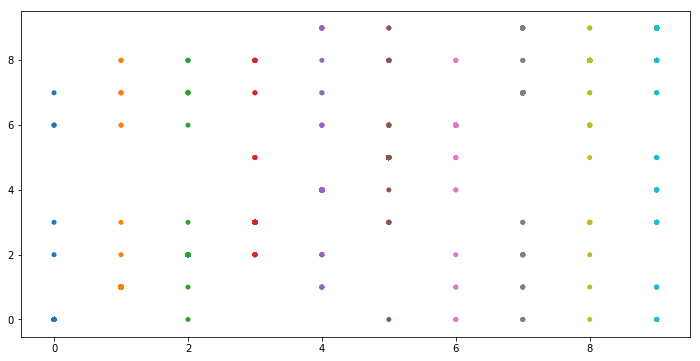

In [12]:
plt.figure(figsize=(12,6))
sns.swarmplot(x='label', y='predict',data=res)
sns.despine(offset=10, trim=True)
plt.xlabel('fault prediction')
plt.grid()
plt.show()

In [13]:
# 4하고 같은 것 8개의 index추출
ver = res.query('label==4').sample(n=8).index 
ver

Int64Index([8107, 9822, 5126, 1159, 1751, 6268, 9735, 3828], dtype='int64')

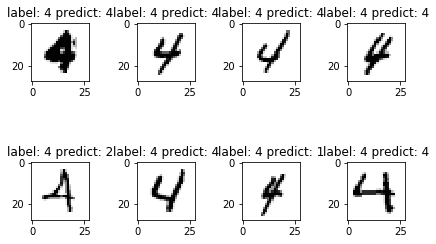

In [17]:
cnt=0
for n in ver:
    cnt+=1
    plt.subplot(2,4,cnt) # 그래프 위치
    plt.imshow(mnist.test.images[n].reshape(28,-1), cmap="Greys")
    t = 'label: '+str(res['label'][n])+' predict: '+str(res['predict'][n])
    plt.title(t)
plt.tight_layout()
plt.show()

# pima 인디안 분석

In [18]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [19]:
# seed 생성
np.random.seed(42)
tf.set_random_seed(42)

In [20]:
data = np.loadtxt("./Datasest/pima-indians-diabetes.csv",delimiter=",")

In [21]:
x = data[:,0:8]
y = data[:,[8]]

x.shape, y.shape

((768, 8), (768, 1))

In [22]:
model = Sequential()
model.add(Dense(units=12, input_dim=8, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# classification문제에서는 binary_crossentropy
# regression문제에서는 categorical_

In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
model.fit(x,y,epochs=200, batch_size=10)




Epoch 1/200
768/768 [==============================] - ETA: 1:19 - loss: 23.9541 - accuracy: 0.400 - ETA: 0s - loss: 14.6655 - accuracy: 0.3525  - 1s 1ms/step - loss: 12.4022 - accuracy: 0.3594
Epoch 2/200
768/768 [==============================] - ETA: 0s - loss: 2.8510 - accuracy: 0.40 - ETA: 0s - loss: 1.7580 - accuracy: 0.53 - 0s 94us/step - loss: 1.6216 - accuracy: 0.5443
Epoch 3/200
768/768 [==============================] - ETA: 0s - loss: 1.3727 - accuracy: 0.60 - ETA: 0s - loss: 1.1570 - accuracy: 0.59 - 0s 86us/step - loss: 1.1509 - accuracy: 0.6029
Epoch 4/200
768/768 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.50 - ETA: 0s - loss: 1.0865 - accuracy: 0.59 - 0s 95us/step - loss: 1.0522 - accuracy: 0.5977
Epoch 5/200
768/768 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.40 - ETA: 0s - loss: 0.9846 - accuracy: 0.59 - 0s 103us/step - loss: 0.9561 - accuracy: 0.5964
Epoch 6/200
768/768 [==============================] - ETA

768/768 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.70 - ETA: 0s - loss: 0.5435 - accuracy: 0.74 - 0s 112us/step - loss: 0.5571 - accuracy: 0.7331
Epoch 42/200
768/768 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.70 - ETA: 0s - loss: 0.5554 - accuracy: 0.71 - ETA: 0s - loss: 0.5701 - accuracy: 0.70 - 0s 152us/step - loss: 0.5825 - accuracy: 0.7005
Epoch 43/200
768/768 [==============================] - ETA: 0s - loss: 0.3553 - accuracy: 0.90 - ETA: 0s - loss: 0.5820 - accuracy: 0.71 - 0s 104us/step - loss: 0.5763 - accuracy: 0.7122
Epoch 44/200
768/768 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.70 - ETA: 0s - loss: 0.5880 - accuracy: 0.71 - 0s 113us/step - loss: 0.5881 - accuracy: 0.7096
Epoch 45/200
768/768 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.60 - ETA: 0s - loss: 0.5985 - accuracy: 0.70 - 0s 105us/step - loss: 0.5648 - accuracy: 0.7227
Epoch 46/200
768/768 [=========

768/768 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.90 - ETA: 0s - loss: 0.5298 - accuracy: 0.75 - 0s 99us/step - loss: 0.5284 - accuracy: 0.7513
Epoch 85/200
768/768 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.60 - ETA: 0s - loss: 0.5247 - accuracy: 0.74 - 0s 112us/step - loss: 0.5197 - accuracy: 0.7474
Epoch 86/200
768/768 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.90 - ETA: 0s - loss: 0.4690 - accuracy: 0.78 - ETA: 0s - loss: 0.5144 - accuracy: 0.75 - 0s 160us/step - loss: 0.5171 - accuracy: 0.7513
Epoch 87/200
768/768 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 1.00 - ETA: 0s - loss: 0.5631 - accuracy: 0.74 - 0s 105us/step - loss: 0.5412 - accuracy: 0.7474
Epoch 88/200
768/768 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.90 - ETA: 0s - loss: 0.5252 - accuracy: 0.75 - 0s 103us/step - loss: 0.5272 - accuracy: 0.7422
Epoch 89/200
768/768 [==========

768/768 [==============================] - ETA: 0s - loss: 0.4122 - accuracy: 0.70 - ETA: 0s - loss: 0.5162 - accuracy: 0.76 - 0s 100us/step - loss: 0.5134 - accuracy: 0.7604
Epoch 128/200
768/768 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.90 - ETA: 0s - loss: 0.4982 - accuracy: 0.76 - 0s 95us/step - loss: 0.4970 - accuracy: 0.7630
Epoch 129/200
768/768 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.90 - ETA: 0s - loss: 0.4688 - accuracy: 0.79 - 0s 98us/step - loss: 0.4918 - accuracy: 0.7734
Epoch 130/200
768/768 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.60 - ETA: 0s - loss: 0.5159 - accuracy: 0.75 - 0s 102us/step - loss: 0.5138 - accuracy: 0.7487
Epoch 131/200
768/768 [==============================] - ETA: 0s - loss: 0.4687 - accuracy: 0.80 - ETA: 0s - loss: 0.4919 - accuracy: 0.77 - 0s 105us/step - loss: 0.4943 - accuracy: 0.7669
Epoch 132/200
768/768 [==============================] - ETA: 0s - loss

Epoch 170/200
768/768 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.70 - ETA: 0s - loss: 0.4979 - accuracy: 0.74 - 0s 91us/step - loss: 0.4902 - accuracy: 0.7487
Epoch 171/200
768/768 [==============================] - ETA: 0s - loss: 0.2954 - accuracy: 0.90 - ETA: 0s - loss: 0.4763 - accuracy: 0.77 - 0s 92us/step - loss: 0.4800 - accuracy: 0.7721
Epoch 172/200
768/768 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.70 - ETA: 0s - loss: 0.4928 - accuracy: 0.73 - 0s 89us/step - loss: 0.4928 - accuracy: 0.7448
Epoch 173/200
768/768 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.80 - ETA: 0s - loss: 0.5111 - accuracy: 0.75 - 0s 90us/step - loss: 0.4999 - accuracy: 0.7604
Epoch 174/200
768/768 [==============================] - ETA: 0s - loss: 0.4699 - accuracy: 0.80 - ETA: 0s - loss: 0.4864 - accuracy: 0.75 - 0s 94us/step - loss: 0.4921 - accuracy: 0.7474
Epoch 175/200
768/768 [==============================] - ETA

In [25]:
model.evaluate(x,y)[1]

768/768 [==============================] - ETA: 19 - 1s 1ms/step


0.7799479365348816

In [26]:
from keras.datasets import mnist
(trainImage,trainLabel),(testImage,testLabel) = mnist.load_data()

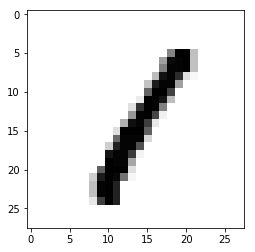

In [30]:
digit = trainImage[3]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [31]:
model2 = Sequential()
model2.add(Dense(512, input_shape=(28*28,), activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [32]:
model2.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy'])

In [33]:
trainImage = trainImage.reshape((60000,-1))
trainImage = trainImage.astype('float32')/255
testImage = testImage.reshape((10000,-1))
testImage = testImage.astype('float32')/255

In [34]:
from keras.utils import to_categorical
trainLabel = to_categorical(trainLabel)
testLabel = to_categorical(testLabel)

In [35]:
# batch_size크기는 2의n승으로 주었을 때 계산을 잘한다.
model2.fit(trainImage, trainLabel, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - ETA: 6:53 - loss: 2.3178 - accuracy: 0.08 - ETA: 1:26 - loss: 1.6156 - accuracy: 0.46 - ETA: 37s - loss: 1.1340 - accuracy: 0.6589 - ETA: 23s - loss: 0.9150 - accuracy: 0.729 - ETA: 17s - loss: 0.8041 - accuracy: 0.765 - ETA: 15s - loss: 0.7352 - accuracy: 0.787 - ETA: 13s - loss: 0.6846 - accuracy: 0.803 - ETA: 11s - loss: 0.6411 - accuracy: 0.816 - ETA: 10s - loss: 0.6093 - accuracy: 0.826 - ETA: 9s - loss: 0.5814 - accuracy: 0.834 - ETA: 8s - loss: 0.5631 - accuracy: 0.84 - ETA: 8s - loss: 0.5465 - accuracy: 0.84 - ETA: 7s - loss: 0.5237 - accuracy: 0.85 - ETA: 7s - loss: 0.5091 - accuracy: 0.85 - ETA: 6s - loss: 0.4949 - accuracy: 0.85 - ETA: 6s - loss: 0.4802 - accuracy: 0.86 - ETA: 6s - loss: 0.4686 - accuracy: 0.86 - ETA: 5s - loss: 0.4576 - accuracy: 0.86 - ETA: 5s - loss: 0.4460 - accuracy: 0.87 - ETA: 5s - loss: 0.4367 - accuracy: 0.87 - ETA: 4s - loss: 0.4288 - accuracy: 0.87 - ETA: 4s - loss: 0.4164 - accuracy: 0.87 -

60000/60000 [==============================] - ETA: 4s - loss: 0.0762 - accuracy: 0.98 - ETA: 3s - loss: 0.0641 - accuracy: 0.98 - ETA: 3s - loss: 0.0631 - accuracy: 0.98 - ETA: 3s - loss: 0.0670 - accuracy: 0.98 - ETA: 3s - loss: 0.0716 - accuracy: 0.98 - ETA: 3s - loss: 0.0679 - accuracy: 0.98 - ETA: 3s - loss: 0.0681 - accuracy: 0.98 - ETA: 3s - loss: 0.0636 - accuracy: 0.98 - ETA: 3s - loss: 0.0650 - accuracy: 0.98 - ETA: 3s - loss: 0.0667 - accuracy: 0.98 - ETA: 3s - loss: 0.0671 - accuracy: 0.98 - ETA: 2s - loss: 0.0678 - accuracy: 0.98 - ETA: 2s - loss: 0.0666 - accuracy: 0.98 - ETA: 2s - loss: 0.0666 - accuracy: 0.98 - ETA: 2s - loss: 0.0658 - accuracy: 0.98 - ETA: 2s - loss: 0.0671 - accuracy: 0.98 - ETA: 2s - loss: 0.0673 - accuracy: 0.97 - ETA: 2s - loss: 0.0676 - accuracy: 0.97 - ETA: 2s - loss: 0.0672 - accuracy: 0.97 - ETA: 2s - loss: 0.0672 - accuracy: 0.97 - ETA: 2s - loss: 0.0674 - accuracy: 0.97 - ETA: 2s - loss: 0.0679 - accuracy: 0.97 - ETA: 2s - loss: 0.0683 - accu

60000/60000 [==============================] - ETA: 4s - loss: 0.0730 - accuracy: 0.96 - ETA: 4s - loss: 0.0381 - accuracy: 0.98 - ETA: 3s - loss: 0.0294 - accuracy: 0.99 - ETA: 3s - loss: 0.0378 - accuracy: 0.98 - ETA: 3s - loss: 0.0350 - accuracy: 0.99 - ETA: 3s - loss: 0.0332 - accuracy: 0.99 - ETA: 3s - loss: 0.0325 - accuracy: 0.99 - ETA: 3s - loss: 0.0357 - accuracy: 0.98 - ETA: 3s - loss: 0.0358 - accuracy: 0.98 - ETA: 3s - loss: 0.0360 - accuracy: 0.99 - ETA: 3s - loss: 0.0354 - accuracy: 0.99 - ETA: 3s - loss: 0.0366 - accuracy: 0.98 - ETA: 3s - loss: 0.0370 - accuracy: 0.98 - ETA: 3s - loss: 0.0361 - accuracy: 0.98 - ETA: 3s - loss: 0.0362 - accuracy: 0.98 - ETA: 3s - loss: 0.0368 - accuracy: 0.98 - ETA: 3s - loss: 0.0372 - accuracy: 0.98 - ETA: 3s - loss: 0.0369 - accuracy: 0.98 - ETA: 3s - loss: 0.0366 - accuracy: 0.98 - ETA: 3s - loss: 0.0365 - accuracy: 0.98 - ETA: 2s - loss: 0.0363 - accuracy: 0.98 - ETA: 2s - loss: 0.0357 - accuracy: 0.98 - ETA: 2s - loss: 0.0358 - accu

In [36]:
loss,accuracy = model2.evaluate(trainImage,trainLabel)
accuracy

60000/60000 [==============================] - ETA: 25:4 - ETA: 1:0 - ETA: 34s - ETA: 24 - ETA: 19 - ETA: 15 - ETA: 12 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 65us/step


0.9916499853134155

### 이미지
> 3차원 : 높이, 너비, 채널

일반적(tensorflow) : 이미지(128, 높이, 너비, 채널)

씨아노 : 이미지(128, 채널, 높이, 너비)

### 비디오
> 5차원, 프레임(이미지)의 연속
(프레임, 높이, 너비, 채널)

ex) 60초 짜리, 100*200 유튜브 비디오
 - 초당 4프레임 샘플링
 - 4*60=240프레임
 - 비디오 클립5개
 
=>(5, 240, 100, 200, 3)

### 영화 리뷰 분류
- 긍정, 부정 분류

In [37]:
from keras.datasets import imdb

In [71]:
# 자주 사용되는 10000개의 단어만 추출
(trainData,trainLabel),(testData,testLabel) = imdb.load_data(num_words=10000)
trainData.shape, trainLabel.shape, testData.shape, testLabel.shape

((25000,), (25000,), (25000,), (25000,))

In [72]:
wordIndex = imdb.get_word_index()
wordIndex

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [73]:
# values, key 위치 변경
rev_wordIndex = dict((values, key) for (key,values) in wordIndex.items())

In [74]:
rev_wordIndex

{34701: 'fawn',
 52006: 'tsukino',
 52007: 'nunnery',
 16816: 'sonja',
 63951: 'vani',
 1408: 'woods',
 16115: 'spiders',
 2345: 'hanging',
 2289: 'woody',
 52008: 'trawling',
 52009: "hold's",
 11307: 'comically',
 40830: 'localized',
 30568: 'disobeying',
 52010: "'royale",
 40831: "harpo's",
 52011: 'canet',
 19313: 'aileen',
 52012: 'acurately',
 52013: "diplomat's",
 25242: 'rickman',
 6746: 'arranged',
 52014: 'rumbustious',
 52015: 'familiarness',
 52016: "spider'",
 68804: 'hahahah',
 52017: "wood'",
 40833: 'transvestism',
 34702: "hangin'",
 2338: 'bringing',
 40834: 'seamier',
 34703: 'wooded',
 52018: 'bravora',
 16817: 'grueling',
 1636: 'wooden',
 16818: 'wednesday',
 52019: "'prix",
 34704: 'altagracia',
 52020: 'circuitry',
 11585: 'crotch',
 57766: 'busybody',
 52021: "tart'n'tangy",
 14129: 'burgade',
 52023: 'thrace',
 11038: "tom's",
 52025: 'snuggles',
 29114: 'francesco',
 52027: 'complainers',
 52125: 'templarios',
 40835: '272',
 52028: '273',
 52130: 'zaniacs',

In [75]:
decReview = " ".join([rev_wordIndex.get(i-3,"?") for i in trainData[0]])
# .get(i-3, '?') : i-3이 없을때(i가 0,1,2,3일때) ?가 대신 들어간다
decReview

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [76]:
# 동일한 길이의 리스트가 되도록 패딩 작업 수행
# 원핫인코딩

In [77]:
# 벡터로 변경
def vec_seq(data, dim=10000):
    res = np.zeros((len(data),dim))
    
    for i,s in enumerate(data):
        res[i,s] = 1
    return res

In [82]:
# 데이터(dictionary) -> 벡터
xTrain = vec_seq(trainData)
xTest = vec_seq(testData)

# 데이터타입 float로 변경
yTrain = trainLabel.astype('float32')
yTest = testLabel.astype('float32')

xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

((25000, 10000), (25000, 10000), (25000,), (25000,))

In [79]:
model = Sequential()
model.add(Dense(16, activation='relu',input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [80]:
model.compile(loss='binary_crossentropy', # 긍정,부정으로 나누기때문에
             optimizer="rmsprop",
             metrics=['accuracy'])

In [83]:
# 훈련, 검증 데이터 나누기
xVal = xTrain[:10000]
p_xTrain = xTrain[10000:]
yVal = yTrain[:10000]
p_yTrain = yTrain[10000:]

p_xTrain.shape, p_yTrain.shape, xVal.shape, yVal.shape

((15000, 10000), (15000,), (10000, 10000), (10000,))

In [84]:
# 훈련
history = model.fit(p_xTrain, p_yTrain,
                    epochs=20, batch_size=512,
                    validation_data=(xVal,yVal))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - ETA: 25s - loss: 0.6921 - accuracy: 0.517 - ETA: 13s - loss: 0.6867 - accuracy: 0.567 - ETA: 9s - loss: 0.6789 - accuracy: 0.571 - ETA: 6s - loss: 0.6708 - accuracy: 0.58 - ETA: 5s - loss: 0.6659 - accuracy: 0.59 - ETA: 4s - loss: 0.6600 - accuracy: 0.60 - ETA: 4s - loss: 0.6504 - accuracy: 0.61 - ETA: 3s - loss: 0.6430 - accuracy: 0.63 - ETA: 3s - loss: 0.6364 - accuracy: 0.64 - ETA: 2s - loss: 0.6282 - accuracy: 0.66 - ETA: 2s - loss: 0.6190 - accuracy: 0.68 - ETA: 2s - loss: 0.6096 - accuracy: 0.69 - ETA: 2s - loss: 0.6018 - accuracy: 0.70 - ETA: 1s - loss: 0.5940 - accuracy: 0.71 - ETA: 1s - loss: 0.5874 - accuracy: 0.72 - ETA: 1s - loss: 0.5810 - accuracy: 0.72 - ETA: 1s - loss: 0.5747 - accuracy: 0.73 - ETA: 1s - loss: 0.5695 - accuracy: 0.73 - ETA: 1s - loss: 0.5629 - accuracy: 0.74 - ETA: 1s - loss: 0.5574 - accuracy: 0.75 - ETA: 0s - loss: 0.5522 - accuracy: 0.75 - ETA: 

Epoch 7/20
15000/15000 [==============================] - ETA: 1s - loss: 0.0735 - accuracy: 0.98 - ETA: 1s - loss: 0.0836 - accuracy: 0.98 - ETA: 1s - loss: 0.0831 - accuracy: 0.97 - ETA: 1s - loss: 0.0854 - accuracy: 0.97 - ETA: 1s - loss: 0.0841 - accuracy: 0.97 - ETA: 1s - loss: 0.0824 - accuracy: 0.97 - ETA: 1s - loss: 0.0848 - accuracy: 0.97 - ETA: 1s - loss: 0.0822 - accuracy: 0.98 - ETA: 1s - loss: 0.0822 - accuracy: 0.97 - ETA: 1s - loss: 0.0843 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 1s - loss: 0.0835 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0834 - accuracy: 0.97 - ETA: 0s - loss: 0.0836 - accuracy: 0.97 - ETA: 0s - loss: 0.0840 - accuracy: 0.97 - ETA: 0s - loss: 0.0843 - accuracy: 0.97 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0861 - accuracy: 0.97 - ETA: 0s - loss: 0.0888 - accuracy: 0.97 - ETA: 0s - loss: 0.0904 - accuracy: 0.97 - ETA: 0s - loss: 0.

Epoch 13/20
15000/15000 [==============================] - ETA: 1s - loss: 0.0176 - accuracy: 1.00 - ETA: 1s - loss: 0.0159 - accuracy: 1.00 - ETA: 1s - loss: 0.0152 - accuracy: 1.00 - ETA: 1s - loss: 0.0145 - accuracy: 1.00 - ETA: 1s - loss: 0.0149 - accuracy: 0.99 - ETA: 1s - loss: 0.0152 - accuracy: 0.99 - ETA: 1s - loss: 0.0158 - accuracy: 0.99 - ETA: 1s - loss: 0.0159 - accuracy: 0.99 - ETA: 1s - loss: 0.0158 - accuracy: 0.99 - ETA: 1s - loss: 0.0161 - accuracy: 0.99 - ETA: 1s - loss: 0.0164 - accuracy: 0.99 - ETA: 1s - loss: 0.0163 - accuracy: 0.99 - ETA: 0s - loss: 0.0166 - accuracy: 0.99 - ETA: 0s - loss: 0.0168 - accuracy: 0.99 - ETA: 0s - loss: 0.0168 - accuracy: 0.99 - ETA: 0s - loss: 0.0168 - accuracy: 0.99 - ETA: 0s - loss: 0.0172 - accuracy: 0.99 - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - ETA: 0s - loss: 0.0185 - accuracy: 0.99 - ETA: 0s - loss: 0.0201 - accuracy: 0.99 - ETA: 0s - loss: 0.0210 - accuracy: 0.99 - ETA: 0s - loss: 0.0213 - accuracy: 0.99 - ETA: 0s - loss: 0

Epoch 19/20
15000/15000 [==============================] - ETA: 1s - loss: 0.0019 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0022 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0023 - accuracy: 1.00 - ETA: 1s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 0.0022 - accuracy: 1.00 - ETA: 0s - loss: 0.0027 - accuracy: 0.99 - ETA: 0s - loss: 0.0027 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0.0026 - accuracy: 0.99 - ETA: 0s - loss: 0

In [85]:
historyDict = history.history
historyDict

{'val_loss': [0.38868126649856566,
  0.3029134303569794,
  0.29768483591079714,
  0.2745501117706299,
  0.2887471413612366,
  0.29535650725364687,
  0.31532480025291443,
  0.35816612582206725,
  0.3601913987159729,
  0.43823960251808164,
  0.423322825717926,
  0.4711313815116882,
  0.4888881323337555,
  0.5161794751644134,
  0.5497036113739013,
  0.5823664332389832,
  0.624622946548462,
  0.6544562960624695,
  0.6808532165527343,
  0.713827829170227],
 'val_accuracy': [0.8672000169754028,
  0.8880000114440918,
  0.8797000050544739,
  0.8895000219345093,
  0.8841999769210815,
  0.8858000040054321,
  0.8809999823570251,
  0.8736000061035156,
  0.8766000270843506,
  0.8720999956130981,
  0.8723000288009644,
  0.8651999831199646,
  0.867900013923645,
  0.8698999881744385,
  0.8715000152587891,
  0.8687999844551086,
  0.8705000281333923,
  0.8668000102043152,
  0.8675000071525574,
  0.8680999875068665],
 'loss': [0.5131507498423259,
  0.3019498235543569,
  0.21935312379201252,
  0.174673681

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

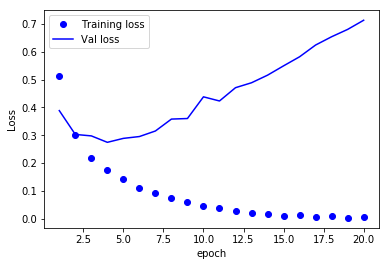

In [87]:
epoch = range(1,len(acc)+1)
plt.plot(epoch, loss,'bo',label="Training loss")
plt.plot(epoch, val_loss,'b',label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

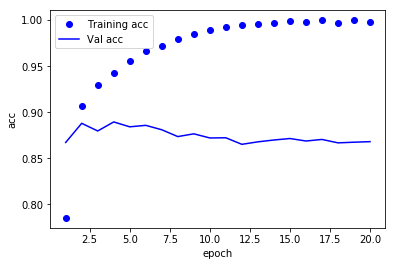

In [88]:
plt.plot(epoch, acc,'bo',label="Training acc")
plt.plot(epoch, val_acc,'b',label="Val acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [89]:
model.evaluate(xTest,yTest)

25000/25000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 4s 151us/step


[0.7755017005324364, 0.8515599966049194]

In [91]:
from keras.datasets import boston_housing
(trainData, trainTarget),(testData,testTarget) = boston_housing.load_data()

57344/57026 [==============================] - ETA:  - ETA:  - 0s 7us/step


loss='mse'
optimizer='rmsprop'
metrics=['mae'] :작을 수록 좋다

keras
tensorflow

iris.csv로 iris 품종 분류기 만들기
loss = 'categorical_crossentropy'
optimizer=adam
metrics = accuracy